# Imports

For now, I will keep the same framework with seq lens (12-16), but this could be subject to change given the amount of data I have.

In [1]:
#Allows relative imports
import os
import sys
import pandas as pd 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports 
from src.preprocessing import *
from src.models import *
from src.train_eval_helpers import *
from src.plots import *
import torch
import torch.nn as nn
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 300
import seaborn as sns
sns.set_style('darkgrid')

#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))

RANGE = range(12,17)
TRAINDIR = '../TrainingData/'

Using : cuda


## EMERSON batch2 (no HLA)

In [2]:
def sign_to_int(sign):
    if sign == '-' : return 0
    if sign == '+' : return 1 
    
def parse_batch2(filename, hla=False):
    """Reads .tsvs from emerson data and parse the sample tags & filters"""
    tmp = pd.read_csv(filename, sep='\t', usecols = ['amino_acid', 'frequency','v_family','v_gene','j_family','j_gene','d_family','d_gene', 'sample_tags'])
    tmp['filename']= os.path.basename(filename)
    #Parsing tags
    tags = tmp.sample_tags.unique()[0].split(',')
    tmp['age'] = tags[0].split(':')[1].split(' ')[0]
    tmp['sex'] = tags[1].split(':')[1]
    tmp['cohort'] = int(tags[2].split('Cohort:Cohort ')[1])
    tmp['true_cmv'] = sign_to_int(tags[-1].split(':Cytomegalovirus ')[1])
    tmp['race'] = tags[5].split('Group:')[1]
    tmp['pred_cmv'] = sign_to_int(tags[4].split(': Inferred CMV ')[1])
    #Filtering NaNs, unresolved, bad sequences
    tmp.drop(columns='sample_tags',inplace=True)
    tmp.dropna(subset=['amino_acid','v_family',	'v_gene','j_family','j_gene'])
    tmp = tmp.query('not (amino_acid.str.contains("\*") or v_family == "TCRBVA")')
    tmp = tmp.query('v_gene!="unresolved" & j_gene != "unresolved"').dropna()
    return tmp

In [83]:
# Parsing batch2
E='../training_data_new/emerson_raw/'
emerson = pd.DataFrame()
from tqdm import tqdm
for f in tqdm(os.listdir(E)):
    tmp = parse_batch2(os.path.join(E, f), hla=False)
    emerson = emerson.append(tmp, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████| 120/120 [08:05<00:00,  4.04s/it]


In [199]:
emerson.to_csv('../training_data_new/emerson_clean_batch2_120samples_vdj.tsv', index=False, header = True, sep='\t')

In [110]:
#Filtering by length, to a separate file
e_dr = emerson.copy()
e_dr['len'] = e_dr.amino_acid.str.len()
#Emerson querying lengths
e_dr.rename(columns={'v_gene':'TRBV', 'j_gene':'TRBJ'}, inplace=True)
e_dr.query('len>=12&len<=16').to_csv('../training_data_new/emerson_batch2_filtered_length_vdj.tsv', sep='\t', 
            header=True, index=False)
e_dr

,amino_acid,frequency,v_family,TRBV,d_family,d_gene,j_family,TRBJ,filename,age,sex,cohort,race,pred_cmv,true_cmv,len
0,CASSSGLVLGNEQFF,0.000006,TCRBV28,TCRBV28-01,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-01,Keck0001_MC1.tsv,22,Female,2,Caucasian,0,1,15
1,CASSYTTSGGNEQFF,0.000006,TCRBV06,TCRBV06-06,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-01,Keck0001_MC1.tsv,22,Female,2,Caucasian,0,1,15
2,CASSLVGGRRNEQFF,0.000006,TCRBV07,TCRBV07-03,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-01,Keck0001_MC1.tsv,22,Female,2,Caucasian,0,1,15
3,CASSSDLAGGSNEQFF,0.000006,TCRBV13,TCRBV13-01,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-01,Keck0001_MC1.tsv,22,Female,2,Caucasian,0,1,16
4,CASSQDGGTPSNEQFF,0.000006,TCRBV14,TCRBV14-01,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-01,Keck0001_MC1.tsv,22,Female,2,Caucasian,0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14835699,CASSYPLPQGKAFF,0.000002,TCRBV06,TCRBV06-05,TCRBD01,TCRBD01-01,TCRBJ01,TCRBJ01-01,Keck0120_MC1.tsv,26,Female,2,Caucasian,0,0,14
14835700,CASSQDRGDREEKAFF,0.000002,TCRBV04,TCRBV04-02,TCRBD01,TCRBD01-01,TCRBJ01,TCRBJ01-01,Keck0120_MC1.tsv,26,Female,2,Caucasian,0,0,16
14835701,CASSEPWTGLTFF,0.000002,TCRBV06,TCRBV06-01,TCRBD02,TCRBD02-01,TCRBJ01,TCRBJ01-01,Keck0120_MC1.tsv,26,Female,2,Caucasian,0,0,13
14835702,CASSIVGPTGRTFF,0.000002,TCRBV19,TCRBV19-01,TCRBD01,TCRBD01-01,TCRBJ01,TCRBJ01-01,Keck0120_MC1.tsv,26,Female,2,Caucasian,0,0,14


In [3]:
#Subsampling
from itertools import product
from tqdm import tqdm
import math
def subsampling(df, frac, RANGE=range(12,17)):
    #Getting combinations of TRBV-J
    trbv = df.TRBV.unique()
    trbj = df.TRBJ.unique()
    combo = list(product(trbv,trbj))
    #result df
    result = pd.DataFrame()
    for V,J in tqdm(combo):
        sub = df.query('TRBV==@V and TRBJ==@J')
        if len(sub)==0:continue 
        for l in RANGE:#For each length,
            tmp = sub.query('len==@l')
            if len(tmp)==0:continue
            n = math.floor(frac*len(tmp))
            result=result.append(tmp.sample(n),ignore_index=True)
    print("Final length :", len(result))
    display(result.head(5))
    return result

In [115]:
emerson_sub = subsampling(e_dr, 0.03)

100%|██████████████████████████████████████████████████████████████████████████████████████| 832/832 [17:44<00:00,  1.28s/it]

Final length : 375488


,amino_acid,frequency,v_family,TRBV,d_family,d_gene,j_family,TRBJ,filename,age,sex,cohort,race,pred_cmv,true_cmv,len
0,CASSQTSGRPFF,0.000008,TCRBV28,TCRBV28-01,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-01,Keck0039_MC1.tsv,27,Male,2,Caucasian,0,0,12
1,CAGTSGTGEQFF,0.000006,TCRBV28,TCRBV28-01,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-01,Keck0015_MC1.tsv,20,Male,2,Asian or Pacific Islander,1,1,12
2,CATRLTNNEQFF,0.000003,TCRBV28,TCRBV28-01,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-01,Keck0078_MC1.tsv,23,Female,2,Caucasian,0,0,12
3,CASSFYRNEQFF,0.000003,TCRBV28,TCRBV28-01,TCRBD01,TCRBD01-01,TCRBJ02,TCRBJ02-01,Keck0083_MC1.tsv,35,Female,2,Caucasian,0,0,12
4,CASSLTSGRQFF,0.000002,TCRBV28,TCRBV28-01,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-01,Keck0074_MC1.tsv,24,Male,2,Caucasian,0,0,12
5,CASSPTDPEQFF,0.000001,TCRBV28,TCRBV28-01,TCRBD01,TCRBD01-01,TCRBJ02,TCRBJ02-01,Keck0069_MC1.tsv,28,Female,2,Caucasian,0,0,12
6,CASRTGFNEQFF,0.000001,TCRBV28,TCRBV28-01,TCRBD01,TCRBD01-01,TCRBJ02,TCRBJ02-01,Keck0095_MC1.tsv,34,Male,2,Caucasian,0,0,12
7,CASGPLGNEQFF,0.000001,TCRBV28,TCRBV28-01,TCRBD01,TCRBD01-01,TCRBJ02,TCRBJ02-01,Keck0069_MC1.tsv,28,Female,2,Caucasian,0,0,12
8,CASSSGRDEQFF,0.000006,TCRBV28,TCRBV28-01,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-01,Keck0046_MC1.tsv,27,Female,2,Caucasian,0,0,12
9,CASSFIVNEQFF,0.000002,TCRBV28,TCRBV28-01,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-01,Keck0114_MC1.tsv,19,Female,2,Caucasian,0,0,12


In [117]:
emerson_sub.to_csv('../training_data_new/emerson_raw/batch2/emerson_batch2_combo_subsampled.tsv', sep='\t', header=True, index=False)

### In-silico sequences (OLGA)

In [118]:
olga = pd.read_csv('../../OLGA/output/test2.tsv', header=None, sep = '\t', names = ['amino_acid','TRBV','TRBJ'])
olga['len'] = olga.amino_acid.str.len()
olga.head()

,amino_acid,TRBV,TRBJ,len
0,CSAREGLLAGINNEQFF,TRBV20-1,TRBJ2-1,17
1,CAKGDRVGNLHNEQFF,TRBV10-3,TRBJ2-1,16
2,CASSEKHSSGDFSSYNEQFF,TRBV10-2,TRBJ2-1,20
3,CASSYSGQGCVYNEQFF,TRBV5-4,TRBJ2-1,17
4,CASSKAGASDNEQYF,TRBV7-9,TRBJ2-7,15


In [119]:
###### Subsampling
olga_sub = subsampling(olga, 0.03)
olga_sub.to_csv('../training_data_new/olga_subsampled_filtered.tsv', sep='\t',
                   header = True, index = False)

100%|██████████████████████████████████████████████████████████████████████████████████████| 624/624 [09:28<00:00,  1.10it/s]

Final length : 524522


,amino_acid,TRBV,TRBJ,len
0,CLPTGLYNEQFF,TRBV20-1,TRBJ2-1,12
1,CSAPQRGNEQFF,TRBV20-1,TRBJ2-1,12
2,CSAPPRVVQQFF,TRBV20-1,TRBJ2-1,12
3,CSARRQKAEQFF,TRBV20-1,TRBJ2-1,12
4,CTRQGARNEQFF,TRBV20-1,TRBJ2-1,12
5,CTPAGVYNEQFF,TRBV20-1,TRBJ2-1,12
6,CSARGLDNEQFF,TRBV20-1,TRBJ2-1,12
7,CKLGISYNEQFF,TRBV20-1,TRBJ2-1,12
8,CSARRGVKEQFF,TRBV20-1,TRBJ2-1,12
9,CSHRASGDEQFF,TRBV20-1,TRBJ2-1,12


NameError: name 'olga_sampled' is not defined

### Naive TCR

In [157]:
naive = pd.read_csv('../training_data_new/naive_filtered_db_TRB.csv')

In [158]:
###### Subsampling
#Getting combinations of TRBV-J
naive_sub = subsampling(naive, 0.1)

100%|██████████████████████████████████████████████████████████████████████████████████████| 832/832 [03:03<00:00,  4.53it/s]

Final length : 390900


,amino_acid,TRBV,TRBJ,len
0,CSPSGVGTEAFF,TRBV29-1,TRBJ1-1,12
1,CSVDTGYNEAFF,TRBV29-1,TRBJ1-1,12
2,CSVVHSNTEAFF,TRBV29-1,TRBJ1-1,12
3,CSVGGPDTEAFF,TRBV29-1,TRBJ1-1,12
4,CSVKLQNTEAFF,TRBV29-1,TRBJ1-1,12
5,CSVEWGGSEAFF,TRBV29-1,TRBJ1-1,12
6,CSVDFEGPEGFF,TRBV29-1,TRBJ1-1,12
7,CSVENRYDKPFF,TRBV29-1,TRBJ1-1,12
8,CSVEGTAYEAFF,TRBV29-1,TRBJ1-1,12
9,CRTDGKNTEAFF,TRBV29-1,TRBJ1-1,12


In [160]:
naive_sub.to_csv('../training_data_new/subsampled/naive_subsampled.tsv', sep = '\t', index=False, header=True)

### Emerson batch 1 

Here a cell where I get only the names of the files containing at least 1 HLA infos

In [ ]:
import zipfile as zf
# Just getting the names of files with all 4 HLa status recovered
E='../training_data_new/emerson_raw/'
file = 'emerson-2017-natgen.zip'
#emerson_b1 = pd.DataFrame()
test = pd.DataFrame()
with zf.ZipFile(E+file, 'r') as zipped:
    a = sorted(zipped.namelist(),key=str)[0:666]
    #Can't parse all at the same time, so I unzip, then parse each file then delete it
    for file in tqdm(a):
        zipped.extract(file, E+'batch1/')
        tmp = pd.read_csv(E+'batch1/'+file,sep='\t', usecols = ['amino_acid', 'sample_tags'], header=0,nrows=1)
        tmp['filename'] = file
        tmp['number_hla'] = len([z for z in (tmp.iloc[[0]].sample_tags.values[0]).split(',') if z.startswith('HLA MHC')]) 
        test=test.append(tmp, ignore_index=True)
        os.remove(os.path.join(E+'batch1/',file))

In [103]:
#Getting the names that have all HLA number resolved        
#names = test.query('number_hla==4').filename.values
#with open('names_hla4.pkl', 'wb') as f:
#    pickle.dump(names, f)
    
#else Getting the filenames of files that don't have 0 HLA resolved
names = test.query('number_hla!=0').filename.values
with open('names_hla_known.pkl', 'wb') as f:
    pickle.dump(names, f)

In [2]:
import pickle
with open('hla_a.pkl', 'rb') as f: 
    HLA_A = pickle.load(f)

with open('hla_b.pkl', 'rb') as f: 
    HLA_B = pickle.load(f)
        

In [8]:
import pandas as pd
xd = pd.read_csv('../training_data_new/emerson_raw/batch1/emerson_batch1_sampletags.tsv', sep='\t')

In [4]:
with open('hla_a.pkl', 'rb') as f: 
    HLA_A = pickle.load(f)

with open('hla_b.pkl', 'rb') as f: 
    HLA_B = pickle.load(f)
        
def get_ab_label(row):
    a1 = row['hla_a1']
    a2 = row['hla_a2']
    b1 = row['hla_b1']
    b2 = row['hla_b2']
    A_label = torch.from_numpy(((HLA_A==a1) | (HLA_A == a2)).astype(int))
    B_label = torch.from_numpy(((HLA_B==b1) | (HLA_B == b2)).astype(int))
    row['A_label'] = A_label
    row['B_label'] = B_label
    return row

# Forget about VDJ genes for now 
#def get_vdj_label(row):
#    v = row['v_gene']
#    j = row['j_gene']
#    

In [5]:
def get_tag(tag, name):
    l = [x.split(name)[1] for x in tag if x.startswith(name)]
    #print(l)
    if len(l) == 0 : return 'Unknown'
    if len(l) == 1 : return l[0]
    else : return l

def parse_batch1(filename, top_n):
    """Reads .tsvs from emerson data and parse the sample tags & filters"""
    #Basic reading and filtering
    tmp = pd.read_csv(filename, sep='\t', usecols = ['amino_acid', 'frequency','v_family','v_gene',
                                                     'j_family','j_gene','d_family','d_gene', 'sample_tags']).dropna()
    tmp['filename']= os.path.basename(filename)
    #Filtering NaNs, unresolved, bad sequences
    tmp.dropna(subset=['amino_acid','v_family',	'v_gene','j_family','j_gene'])
    tmp = tmp.query('not (amino_acid.str.contains("\*") or v_family == "TCRBVA")')
    tmp = tmp.query('v_gene!="unresolved" & j_gene != "unresolved"').dropna()
    tmp = tmp.sort_values('frequency', ascending=False).head(top_n)

    #Parsing tags
    tags = tmp.sample_tags.unique()[0].split(',')
    age = get_tag(tags, 'Age:')
    if get_tag(tags, 'Virus Diseases:') == 'Unknown':
        tmp['pred_cmv'] = 'Unknown'
        tmp['true_cmv'] = 'Unknown'
    else: 
        tmp['pred_cmv'] = sign_to_int(get_tag(tags, 'Inferred CMV status:').split('CMV ')[1])
        tmp['true_cmv'] = sign_to_int(get_tag(tags, 'Virus Diseases:').split('Cytomegalovirus ')[1])
    
    #Bypassing blank age
    if age == 'Unknown': tmp['age'] = age
    else: tmp['age'] = int(age.split(' ')[0])
    #no issue here
    tmp['sex'] = get_tag(tags,'Biological Sex:')
    
    #getting unknown instead of unknown racial group
    race = get_tag(tags, 'Racial').split(':')[1]
    if race.startswith('Unknown'):
        tmp['race'] = 'Unknown'
    else : tmp['race'] = race
        
    #Initializing columns to Unknown to facilitate labels parsing in case of missing alleles
    tmp[['hla_a1', 'hla_a2', 'hla_b1', 'hla_b2']]= 'Unknown'
    
    #Getting HLA columns, then the A and B labels
    HLA = get_tag(tags,'HLA MHC class I:')
    a = len([x for x in HLA if x.startswith('HLA-A')])
    b = len([x for x in HLA if x.startswith('HLA-B')])
    for x in range(a):
        tmp['hla_a'+str(x+1)] = ''.join(HLA.pop(0).split('HLA-')[1].split('*'))
    for x in range(b):
        tmp['hla_b'+str(x+1)] = ''.join(HLA.pop(0).split('HLA-')[1].split('*'))
    
    #tmp[['hla_a1', 'hla_a2', 'hla_b1', 'hla_b2']] = tmp[['hla_a1', 'hla_a2', 'hla_b1', 'hla_b2']].fillna('Unknown')
    tmp = tmp.apply(get_ab_label, axis=1)
    tmp.drop(columns='sample_tags',inplace=True)
    return tmp

#### See cells above for parsing functions

In [ ]:
import zipfile as zf
# Parsing batch1
E='../training_data_new/emerson_raw/'
file = 'emerson-2017-natgen.zip'
emerson_parsed = pd.DataFrame(columns=['amino_acid', 'frequency', 'v_family', 'v_gene', 'd_family', 'd_gene',
       'j_family', 'j_gene', 'filename', 'pred_cmv', 'true_cmv', 'age', 'sex',
       'race', 'hla_a1', 'hla_a2', 'hla_b1', 'hla_b2', 'A_label','B_label'])

with open('names_hla_known.pkl','rb') as g:
    names = pickle.load(g)

with zf.ZipFile(E+file, 'r') as zipped:
    #Can't parse all at the same time, so I unzip, then parse each file then delete it
    BATCH1 = sorted(names,key=str) #HERE PARSING ALL the files that have at least 1 known HLA
    for file in tqdm(BATCH1):
        zipped.extract(file,E+'batch1/')
        filename = os.path.join(E+'batch1/',file)
        emerson_parsed=emerson_parsed.append(parse_batch1(filename,40000), ignore_index=True)
        os.remove(filename)

emerson_parsed.to_csv('../training_data_new/emerson_raw/batch1/emerson_b1_hla_labeled_parsed_tagged.tsv', sep = '\t', header = True, index = False)

In [22]:
emerson_parsed.columns

Index(['amino_acid', 'frequency', 'v_family', 'v_gene', 'd_family', 'd_gene',
       'j_family', 'j_gene', 'filename', 'pred_cmv', 'true_cmv', 'age', 'sex',
       'race', 'hla_a1', 'hla_a2', 'hla_b1', 'hla_b2', 'A_label', 'B_label'],
      dtype='object')

In [25]:
emerson_parsed.to_csv('../training_data_new/emerson_raw/batch1/emerson_b1_basic_infos_parsed_tagged.tsv',
                      columns = ['amino_acid', 'frequency', 'v_gene', 'j_gene', 'filename', 'hla_a1', 'hla_a2', 'hla_b1', 'hla_b2'],
                      header = True, index = False)

MemoryError: Unable to allocate 3.50 GiB for an array with shape (19, 24693423) and data type object

### Reloading Emerson (03.02.21)

In [6]:
emerson_parsed = pd.read_csv('../training_data_new/emerson_raw/batch1/emerson_batch1_626hla_parsed_tagged.tsv', sep='\t', header=0)
sample1= pd.read_csv('../training_data_new/emerson_raw/batch1/emerson_batch1_sampletags.tsv', header=0, sep='\t')
sample1 = sample1.apply(get_ab_label,axis=1)

C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
emerson_parsed.v_gene.unique()

In [ ]:
def get_ab_label(row):
    a1 = row['hla_a1']
    a2 = row['hla_a2']
    b1 = row['hla_b1']
    b2 = row['hla_b2']
    A_label = torch.from_numpy(((HLA_A==a1) | (HLA_A == a2)).astype(int))
    B_label = torch.from_numpy(((HLA_B==b1) | (HLA_B == b2)).astype(int))
    row['A_label'] = A_label
    row['B_label'] = B_label
    return row

def get_vdj_label(row):
    v = row['v_gene']
    j = row['j_gene']
    

In [8]:
emerson_parsed.columns

Index(['amino_acid', 'frequency', 'v_family', 'v_gene', 'd_family', 'd_gene',
       'j_family', 'j_gene', 'filename', 'pred_cmv', 'true_cmv', 'age', 'sex',
       'race', 'hla_a1', 'hla_a2', 'hla_b1', 'hla_b2'],
      dtype='object')

In [6]:
emerson_parsed.v_gene.unique(), emerson_parsed.j_gene.unique()

(array(['TCRBV10-03', 'TCRBV07-09'], dtype=object),
 array(['TCRBJ02-03', 'TCRBJ01-02'], dtype=object))

In [ ]:
print('HLA')
emerson_parsed = emerson_parsed.apply(convert_HLA,axis=1)
print('RACE')
emerson_parsed['race'] = emerson_parsed.apply(convert_unknown, axis =1)
#emerson_parsed[emerson_parsed'class'] = emerson_parsed.apply(get_class, axis=  1)
print('Saving...')
emerson_parsed.to_csv('../training_data_new/emerson_raw/batch1/emerson_batch1_626hla_top50k_parsed_tagged.tsv', sep='\t', header=True, index=False)
print("Saving done")

In [23]:
#Getting one sample per file as to get all the tags (easier to use than a df with 15 10e6 entries)
sample1 = pd.DataFrame()

for f in tqdm(emerson_parsed['filename'].unique()):
    sample1 = sample1.append(emerson_parsed.query('filename==@f').sort_values('frequency',ascending=False)[['filename', 'pred_cmv', 'true_cmv', 'age', 'sex', 'race', 'hla_a1', 'hla_a2', 'hla_b1', 'hla_b2']].head(1), ignore_index=True)

# sample1 = sample1.apply(convert_HLA,axis=1)
# sample1['race'] = sample1.apply(convert_unknown, axis =1)
# sample1['class'] = sample1.apply(get_class, axis=  1)
display(sample1.head())

100%|██████████████████████████████████████████████████████████████████████████████████████| 626/626 [04:28<00:00,  2.33it/s]


,filename,pred_cmv,true_cmv,age,sex,race,hla_a1,hla_a2,hla_b1,hla_b2,class
0,HIP00110.tsv,0,0,55,Male,Unknown,A03,A24,B07,Unknown,A03-A24-B07
1,HIP00169.tsv,0,0,41,Male,Unknown,A01,A02,B27,B37,A01-A02-B27-B37
2,HIP00594.tsv,1,1,21,Male,Caucasian,A02,A32,B07,B61,A02-A32-B07-B61
3,HIP00602.tsv,0,0,45,Female,Unknown,A02,A11,B35,B51,A02-A11-B35-B51
4,HIP00614.tsv,0,0,27,Male,Caucasian,A03,A29,B07,Unknown,A03-A29-B07


In [27]:
sample1.to_csv('../training_data_new/emerson_raw/batch1/emerson_batch1_sampletags.tsv', sep='\t', header=True, index=False)

In [92]:
for x in range (1,7):
    print(x, len(sample1.groupby('class').agg(count=('filename','count')).query("count==@x")))
display(sample1.groupby('class').agg(count=('filename','count')).sort_values('count',ascending=False).head(15))

,count
class,
HLA-A*01-HLA-A*02-HLA-B*08-HLA-B*51,6
HLA-A*01-HLA-A*02-HLA-B*08-HLA-B*44,6
HLA-A*02-HLA-A*03-HLA-B*07-HLA-B*27,5
HLA-A*01-HLA-A*02-HLA-B*08-HLA-B*27,4
HLA-A*01-HLA-A*03-HLA-B*08-HLA-B*35,4
HLA-A*01-HLA-A*02-HLA-B*08-HLA-B*62,4
HLA-A*01-HLA-A*03-HLA-B*07-HLA-B*08,4
HLA-A*03-HLA-A*29-HLA-B*07-HLA-B*44,3
HLA-A*02-HLA-A*03-HLA-B*07-HLA-B*44,3


Text(0.5, 0, 'Number of patients for a given "class"')

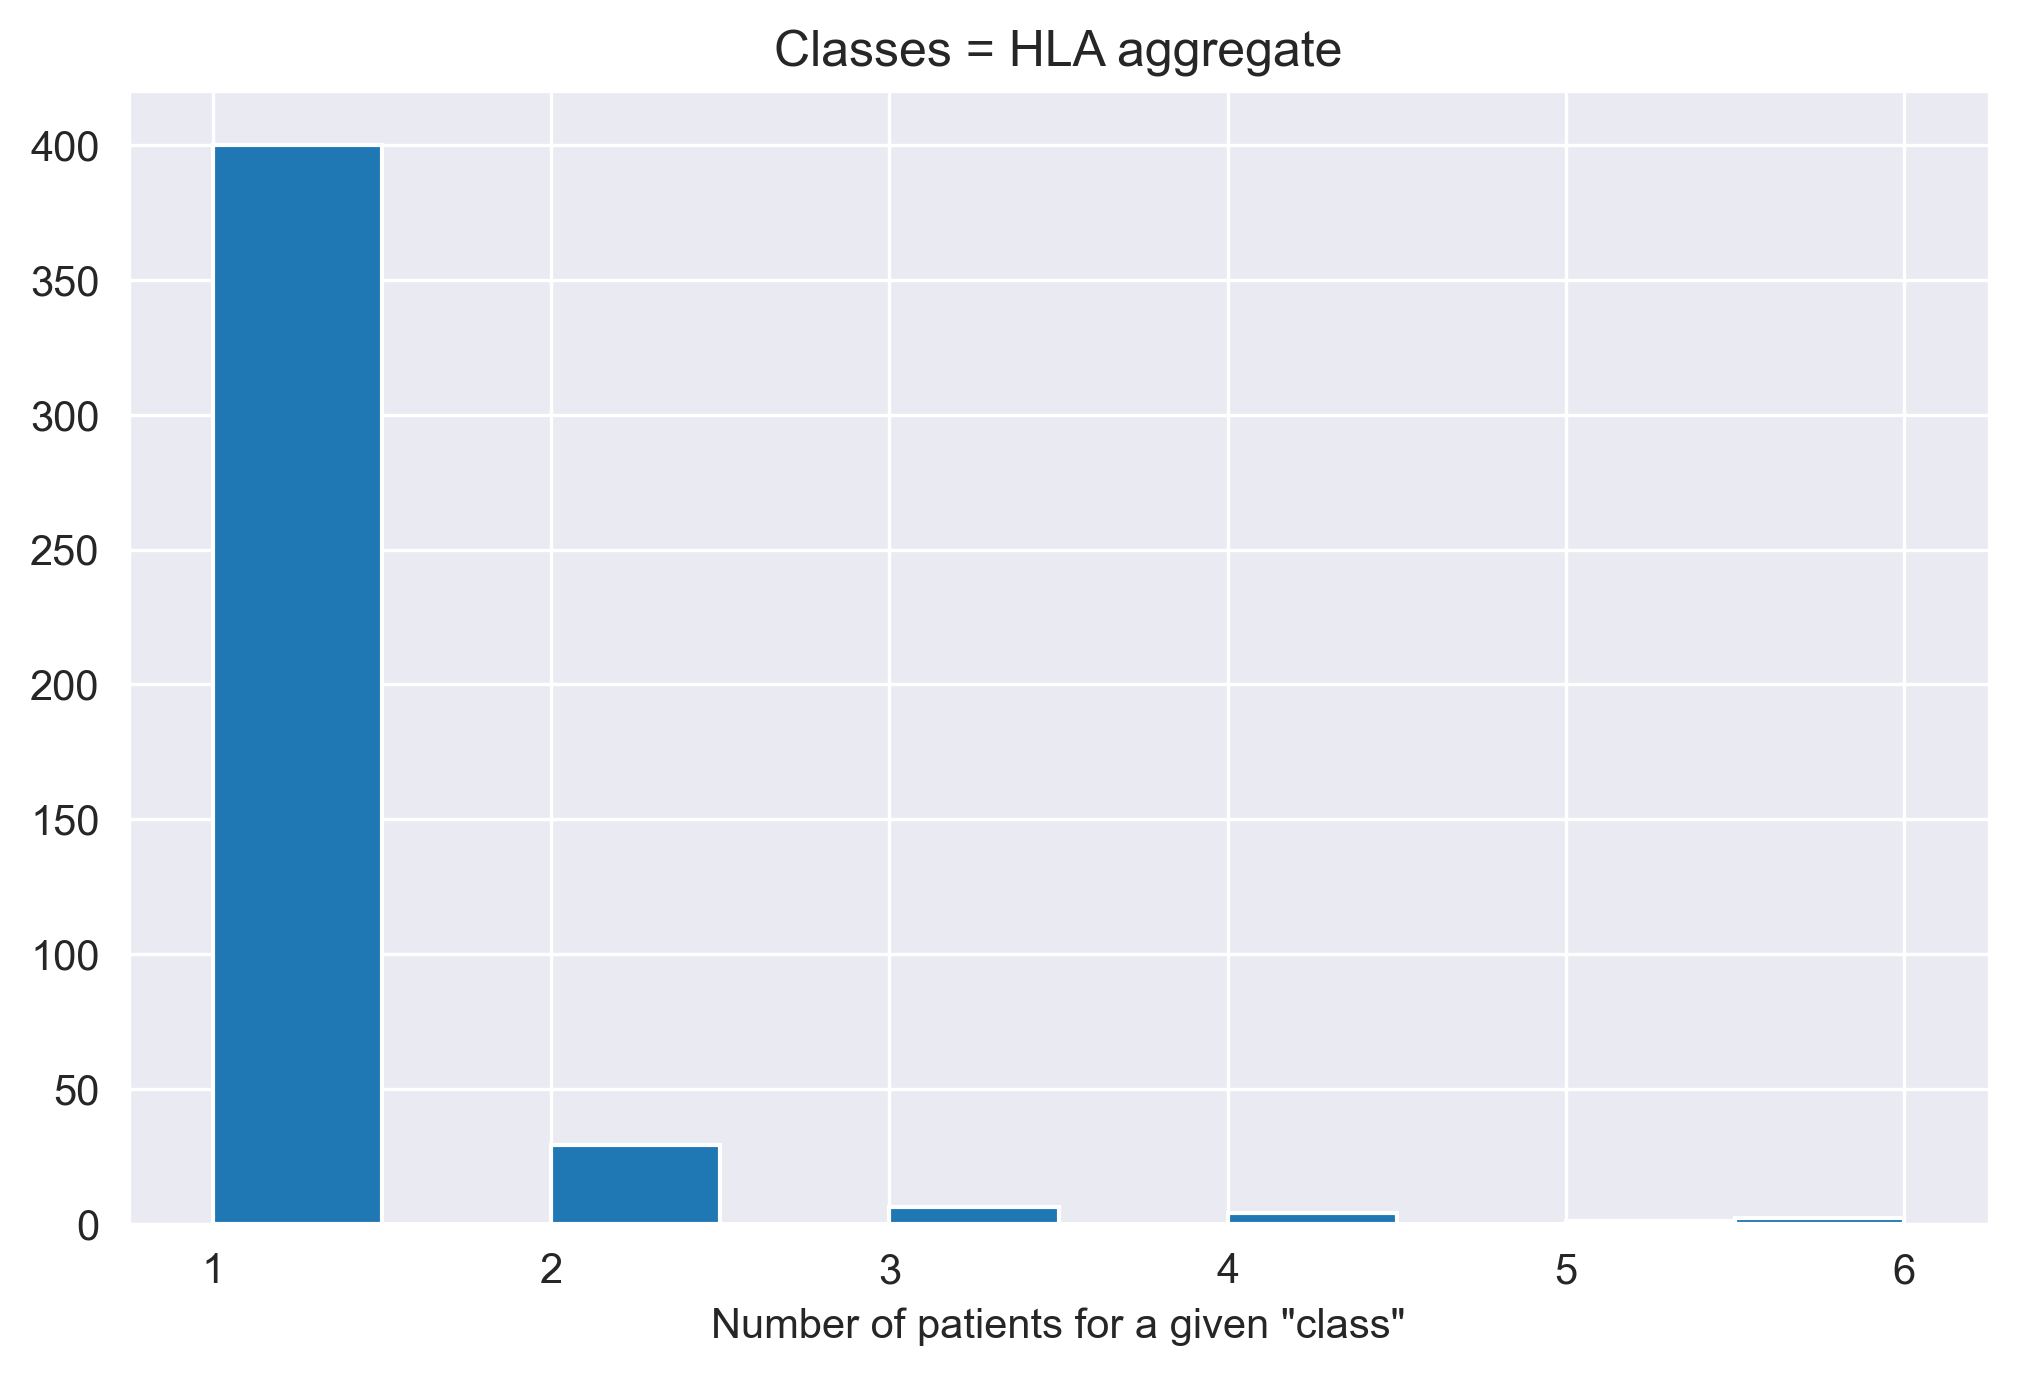

In [87]:
f,a = plt.subplots(1,1,figsize=(8,5))
sample1.groupby('class').agg(count=('filename','count')).hist(ax=a, align='mid')
a.set_title('Classes = HLA aggregate')
a.set_xlabel('Number of patients for a given "class"')

In [ ]:
for f in tqdm(sample1.filename.unique()):
    index = emerson_parsed['filename']==f
    emerson_parsed.loc[index, 'A_label'] = sample1.query('filename==@f')['A_label']
    emerson_parsed.loc[index, 'B_label'] = sample1.query('filename==@f')['B_label']

 25%|█████████████████████▏                                                                | 154/626 [04:48<14:31,  1.85s/it]